---------------------------------------------
- Wiley Winters
- MSDS 640 - Assignment 6 Social Media Analysis for the Common Good
- 2025-AUG-16

------------------------------------------------------------------------
# Assignment Specification
For this week's assignment, you are tasked with write report APA-formatted paper (3-4 pages long). Assume the role of a data science researcher employed at a non-profit organization, approaching the topic from a data science's perspective.
- Your main objective is to utilize social media data to contribute to a common good issue. Choose a topic such as **mental health**, **income inequality**, **human rights**, **workers' rights**, a particular **healthcare concern**, or **socioeconomic injustices**. Select a social media platform for data collection, and options include Reddit, X (formerly Twitter), Facebook, or others
- At a minimum create the wordcloud and include it in your paper. To go above and beyond, apply other NLP and text analytics techniques, such as [topic modeling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and sentiment analysis. Note that many people consider wordclouds uninformative and [bad practice](https://getthematic.com/insights/word-clouds-harm-insights/), so you should strive to create a bar chart of top wordcloud or other visualizations instead, which can be done using tools and examples provided in resources like "MSDS640_Week6_FTE.ipynb"
- Your paper should also feature a mindmap. This mindmap should center around the common good issue you have selected, with social media platforms branching out from the center. Further layers can delve into ethics and privacy concerns related to the project, culminating in examples of these issues
- In your work, include an overall ***introduction***, a ***description of your dataset***, the ***purpose** behind your research, highlighting the problem you seek to address, and a discussion on ethics and privacy challenges in the context of your chosen common good issue. Additionally, provide a summary of your findings. For further insights and inspiration, refer to the weekly reading list, which includes videos and mind-mapping resources

-------------------------------------------------------------------------------
## Import Required Packages and Libraries

In [1]:
# Standard Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys

# Read sqlite3 database file
import sqlite3

# Text processing and preparation
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, words
from collections import Counter

# Text Visualization
from wordcloud import WordCloud

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Make plots pretty
plt.style.use('ggplot')

## Define Functions

Process text function to perform basic preprocessing on text features.  I changed this function to use lemmatization instead of stemming.  While stemming can be faster to perform, lemmatization actually reduces the word-forms to linguistically valid lemmas.

In [2]:
def process_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert all to lower case
        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])
        text = ''.join([char for char in text if not char.isdigit()])  # Remove numbers
        # In some instances, I've run into issues with extra spaces.
        text = text.strip()
        # Remove stop words and apply lemmatizer
        stop = stopwords.words('english')
        wnl = WordNetLemmatizer()
        text = ' '.join([wnl.lemmatize(word) for word in text.split() if word not in \
                         stop])

        return text
    else:
        return ' '

I chose to download **Reddit** submissions and their associated comments.  Since the relationship between submissions and comments are one to many, I decided to store the data in a *sqlite3* datafile.  This will allow me to query the data using standard SQL statements that allows for one to many SQL joins.

The code below creates a connection to the datafile and then queries it based on criteria I have chosen.  A pandas dataframe is created from the query.

Since I believe the purpose of the lab is to perform a sentiment analysis, I will only load text features.

In [3]:
conn = sqlite3.connect('data/poverty.sqlite')  # Create the database connection object

reddit_df = pd.read_sql_query('SELECT id, created_utc, title, author, n_comments, ' \
                              'score, ratio, text, comment_id, comment_utc, ' \
                              'comment_author, body, comment_score ' \
                              'FROM posts, comments WHERE posts.id = comments.link_id ' \
                              'AND n_comments > 0', conn)
# Take a quick peek at the data
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
889,1mbceud,1.753698e+09,Poor people can't have both kids and money,Grouchy_Key4343,271,1160,0.96,"The way I see things, if you were born poor an...",n5tcjb1,1.753805e+09,Point_Plastic,Yeah that’s by design,1
2572,1mh3nii,1.754281e+09,I think a lot of us can survive on Costco hot ...,Apprehensive_Name445,220,323,0.92,I have been going to these places everyday and...,n6xjtc7,1.754338e+09,OwenIowa22,Richy rich with the kitchen,7
2568,1mh3nii,1.754281e+09,I think a lot of us can survive on Costco hot ...,Apprehensive_Name445,220,323,0.92,I have been going to these places everyday and...,n6xbwxh,1.754336e+09,Known_Ratio5478,I pick it apart for loaded quesadillas.,3
8135,1lozctc,1.751370e+09,Is having a male friend help with laundry weird?,None,19,2,0.75,"I'm jobless, i sucked up my pride and am takin...",n2bg8qh,1.752128e+09,Briilliant_Bob,I'm confused. ??? \n\nHe is the one offering t...,1
1586,1m3jg9t,1.752887e+09,The struggle is real.,Apprehensive_Snow45,273,876,0.98,I'm fresh out of prison and I'm feeling overwh...,n46kb3z,1.753026e+09,Apprehensive_Snow45,Thank you🙏,1


The dates are in Unix Epoch.  I will convert them into something a little more human readable.

In [4]:
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'], unit='s')
reddit_df['comment_utc'] = pd.to_datetime(reddit_df['comment_utc'], unit='s')
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
5853,ixsuhf,2020-09-22 18:10:57,What did you do to get yourself out of poverty...,After-Midnight-8422,7,17,1.00,"I tend to assume that at some point, it's nece...",g69rujx,2020-09-23 00:35:58,justcrazytalk,I ate a lot of bread and peanut butter back in...,6
4161,1dzjm35,2024-07-10 01:35:55,Families with kids: What would genuinely help ...,igotyoubabe97,59,75,0.97,My neighbor is in poverty. They’ve confided in...,lclza4v,2024-07-11 01:47:40,boopboopbeepbeep11,You could try paying their electric and water ...,1
2568,1mh3nii,2025-08-04 04:09:24,I think a lot of us can survive on Costco hot ...,Apprehensive_Name445,220,323,0.92,I have been going to these places everyday and...,n6xbwxh,2025-08-04 19:30:56,Known_Ratio5478,I pick it apart for loaded quesadillas.,3
1324,1ltzrkv,2025-07-07 17:07:25,"How the BBB will affect single, childless, poo...",Public-Tailor729,401,1145,0.96,**Federal Student Loans** \nYou won’t be elig...,n2mep2l,2025-07-11 21:22:46,Chicagogirl72,That’s weird. Everyone I know voted for him (I...,0
7359,lai9nh,2021-02-02 00:03:41,I'm interested in a good starting point to lea...,NerdWaanabe,3,7,0.89,This is something I'm newly trying to understa...,glqszv8,2021-02-02 15:58:56,NerdWaanabe,Great comments so far this is amazing and I wi...,1


From previous experiences with this dataset, I know when a comment is removed or deleted, the `body` text is replaced with `[deleted]` or `[removed]`.  I will take a look to see if the count of those comments is significant

In [5]:
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                74
created_utc       74
title             74
author            74
n_comments        74
score             74
ratio             74
text              74
comment_id        74
comment_utc       74
comment_author    74
body              74
comment_score     74
dtype: int64
id                75
created_utc       75
title             75
author            75
n_comments        75
score             75
ratio             75
text              75
comment_id        75
comment_utc       75
comment_author    75
body              75
comment_score     75
dtype: int64


The number is not significant so I will drop these rows.  Its less than 1% of the dataset.

In [6]:
indexBody = reddit_df[(reddit_df['body'] == '[deleted]') | \
                      (reddit_df['body'] =='[removed]')].index
reddit_df.drop(indexBody, inplace=True)
print(reddit_df[reddit_df['body'] == '[deleted]'].count())
print(reddit_df[reddit_df['body'] == '[removed]'].count())

id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64
id                0
created_utc       0
title             0
author            0
n_comments        0
score             0
ratio             0
text              0
comment_id        0
comment_utc       0
comment_author    0
body              0
comment_score     0
dtype: int64


In [7]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 8258
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8110 non-null   object        
 1   created_utc     8110 non-null   datetime64[ns]
 2   title           8110 non-null   object        
 3   author          8110 non-null   object        
 4   n_comments      8110 non-null   int64         
 5   score           8110 non-null   int64         
 6   ratio           8110 non-null   float64       
 7   text            8110 non-null   object        
 8   comment_id      8110 non-null   object        
 9   comment_utc     8110 non-null   datetime64[ns]
 10  comment_author  8110 non-null   object        
 11  body            8110 non-null   object        
 12  comment_score   8110 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(7)
memory usage: 887.0+ KB


In [8]:
reddit_df['text'].map(len).value_counts().sample(10)

text
182     25
171     40
690      4
520     19
3864     8
498     21
892      1
129      4
243      7
443     10
Name: count, dtype: int64

-------------------------------------------------------------------------------
### Preprocess Text

In order to conduct an meaningful EDA of the text data, I will apply some basic NLTK preprocessing to it.  This includes removing punctuation, converting all to lower case, removing numbers, extra spaces, stop words, and breaking words down to their *lemmas*.  I have defined a function to carry out these tasks.  I am concentrating on the `title` and `body` features, but will also process `author` and `comment_author`.

In [9]:
cols = ['title', 'body', 'author', 'comment_author']
for col in cols:
    reddit_df[col] = reddit_df[col].apply(process_text)
reddit_df.sample(5)

,id,created_utc,title,author,n_comments,score,ratio,text,comment_id,comment_utc,comment_author,body,comment_score
1721,1jtvk77,2025-04-07 20:34:01,moved,chocolatesmartbar,53,762,0.99,I made a post last month about how unbearable ...,mmcdq7r,2025-04-10 05:41:59,vividtrue,im sorry youre living nightmare never way wors...,2
7130,1c3wg1r,2024-04-14 15:40:23,living mold,none,11,9,0.91,I have shelter with air conditioning for the T...,l33ukxn,2024-05-08 09:21:01,beanzoup,bleach make mold grow worse,3
1134,1ltzrkv,2025-07-07 17:07:25,bbb affect single childless poor adult,publictailor,401,1145,0.96,**Federal Student Loans** \nYou won’t be elig...,n24znp6,2025-07-09 08:07:13,superlychee,friend making k year service industry pretty s...,0
3711,1kzo85w,2025-05-31 04:14:32,people fucking sympathy poor people,differentlychee,31,85,0.94,I had this stupid-ass argument with this assho...,mv73oyi,2025-05-31 05:01:06,differentlychee,making fun poor people regardless disgusting w...,8
1499,1m3jg9t,2025-07-19 01:11:14,struggle real,apprehensivesnow,273,876,0.98,I'm fresh out of prison and I'm feeling overwh...,n3y8ngz,2025-07-19 05:59:45,none,don’t go back,1


For this study, I am mostly concern with the text data in the `title` and `body` features.  In order to make processing easier, I will merged the two.  I will also add in `author` and `comment_author` to add more words to be clustered.

In [10]:
reddit_df['content'] = reddit_df['title'] + reddit_df['body'] + \
                       reddit_df['author'] + reddit_df['comment_author']
reddit_df['content'].sample(5)

2772    barely food get year oldrice bean cheap colleg...
3395    hey guy i’m writing poverty composition class ...
5409    anyone successfully gotten povertyjoined milit...
4460    find job broke afdont look job destroycrcrhnew...
5994    know i’ll end poverty alone dont take step mov...
Name: content, dtype: object

-------------------------------------------------------------------------------
## Perform some Basic EDA

In [11]:
print(reddit_df.info())
print('\nDataset shape: ', reddit_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 8258
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8110 non-null   object        
 1   created_utc     8110 non-null   datetime64[ns]
 2   title           8110 non-null   object        
 3   author          8110 non-null   object        
 4   n_comments      8110 non-null   int64         
 5   score           8110 non-null   int64         
 6   ratio           8110 non-null   float64       
 7   text            8110 non-null   object        
 8   comment_id      8110 non-null   object        
 9   comment_utc     8110 non-null   datetime64[ns]
 10  comment_author  8110 non-null   object        
 11  body            8110 non-null   object        
 12  comment_score   8110 non-null   int64         
 13  content         8110 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(8)
memory 

The dataset contains 10,000 rows and 13 columns.  There are no NaN values and the datatypes include *datetime64[ns]*, *int64*, *float64*, and *object*.  For this analysis, I am concentrating on *object* text data.

**List the top 10 Words**



In [12]:
freq = pd.Series(' '.join(reddit_df['content']).split()).value_counts(ascending=False).to_dict()
print('Top 10 Words:')
list(freq.items())[:10] # using list to make the output more readable.

Top 10 Words:


[('people', 4081),
 ('poor', 3150),
 ('get', 2365),
 ('like', 1822),
 ('make', 1679),
 ('poverty', 1457),
 ('would', 1441),
 ('money', 1395),
 ('work', 1300),
 ('thing', 1277)]

In [13]:
plot_list = pd.DataFrame(list(freq.items())[:10], columns=['Word','Frequency'])
plot_list

,Word,Frequency
0,people,4081
1,poor,3150
2,get,2365
3,like,1822
4,make,1679
5,poverty,1457
6,would,1441
7,money,1395
8,work,1300
9,thing,1277


**Create Plot of Top Ten Words**

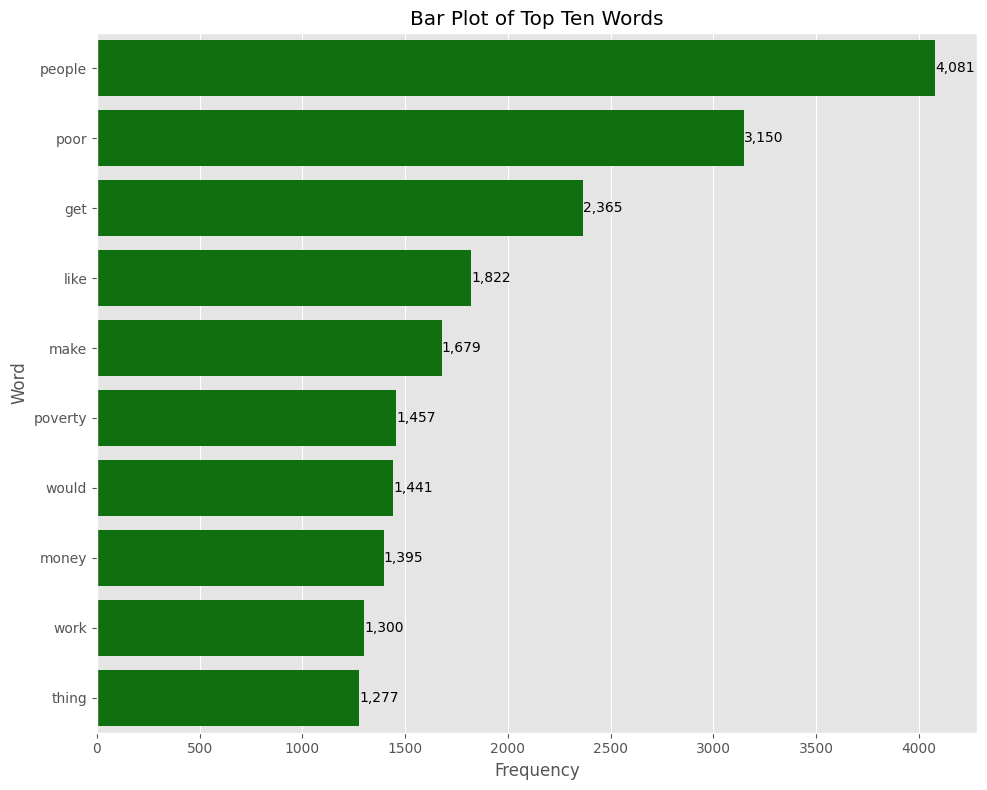

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel='Frequency', ylabel = 'Word', title = 'Bar Plot of Top Ten Words')
sns.barplot(x='Frequency', y='Word', data=plot_list, color='green')
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
plt.tight_layout()
plt.show()
fig.savefig('figures/barplotWordCount.png', bbox_inches='tight', dpi=300) 

**Create a WordCloud from Text Data**

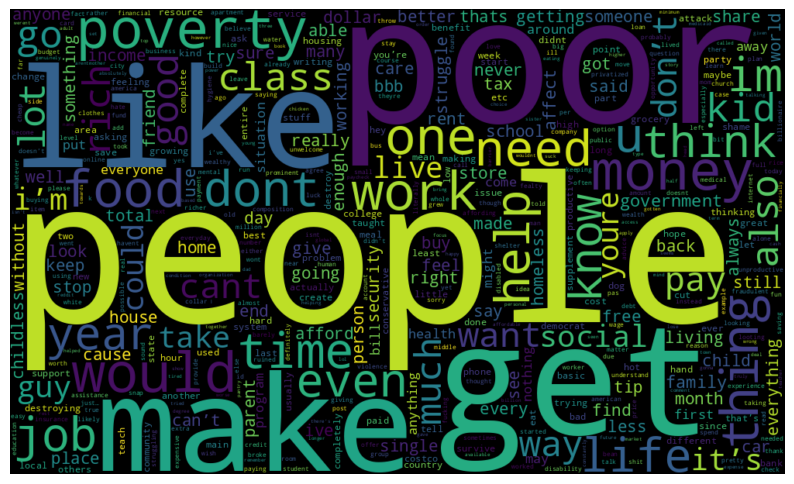

<Figure size 640x480 with 0 Axes>

In [30]:
wc = WordCloud(width=1000, height=600, max_words=500).generate_from_frequencies(freq)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('figures/wordCloud.png', bbox_inches='tight', dpi=300)

The word cloud along with the top 10 word list can give a person a really good idea of what SubReddit was downloaded.  The most used words such as *moon*, *space*, *earth*, and *astronaut* are really good indicators of the subject under discussion.